# Power Spectrum Estimation

This notebook is to understand the details of the power spectrum, its computation with FFT, carefully considering scaling issues, units and interpretation.

Create a discrete sinusoid signal with some added noise. We assume that this is a voltage signal.

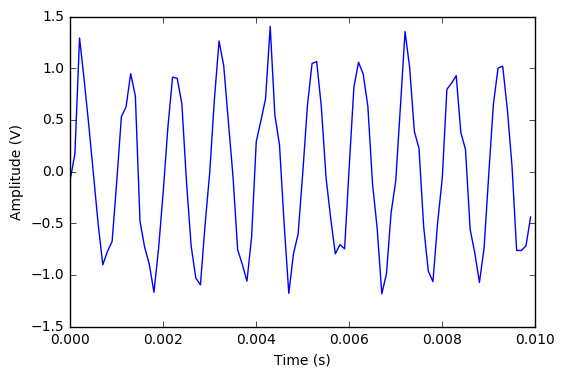

In [38]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal

# constants
FS = 1e4        # sampling rate (Hz)
SIG_F = 1e3     # signal frequency (Hz)
SIG_DB = 0      # signal amplitude (dB)
NOISE_DB = -15  # noise amplitude (dB)
T = 1           # signal length (s)
dT = 1 / FS

t = np.arange(0, T, 1/FS)
sig = np.sin(2 * np.pi * SIG_F * t) * (10 ** (SIG_DB / 20))
noise = np.random.randn(sig.size) * (10 ** (NOISE_DB / 20))
samples = sig + noise

plt.plot(t[:100], samples[:100])
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (V)')

Calculate the average power of the clean signal and of the noise from the time domain samples. Compute SNR. 

__Note__: the power of a sinusoid with unit amplitude is -3dB.

In [39]:
P_sig_t = np.mean(sig ** 2) # same as np.sum((sig ** 2) * dT) / T
P_noise_t = np.mean(noise ** 2)
SNR_t = 10 * np.log10(P_sig_t / P_noise_t)

print('P(sig)= %.2f V^2, P(noise)= %.2f V^2, SNR= %.2f dB' % (P_sig_t, P_noise_t, SNR_t))
print('RMS(sig)= %.2f V, RMS(noise)= %.2f V' % (np.sqrt(P_sig_t), np.sqrt(P_noise_t)))

P(sig)= 0.50 V^2, P(noise)= 0.03 V^2, SNR= 12.02 dB
RMS(sig)= 0.71 V, RMS(noise)= 0.18 V


Compute the DFT of the time domain samples using a fixed length (N). 

__Note__: the DFT results have to be scaled by 1/sqrt(N) to conserve energy (unitary operator). You can achieve the same results with `np.fft.fft(samples, norm='ortho')`. Also, see Parseval's Theorem.

In [40]:
N = 1000      # must be even for these computations

X = np.fft.fft(samples, n=N) / np.sqrt(N)
f = np.fft.fftfreq(N, dT)
# Verify if time and frequency domain energies are the same
np.sum(np.abs(X) ** 2), np.sum(samples[:N] ** 2)

(529.78319252408983, 529.78319252409005)

First important observation: the squared magnitude of the FFT values represent the __energy__ distribution across the frequency bins for the given signal length (N). Thus, the absolute bin values depend on N. 

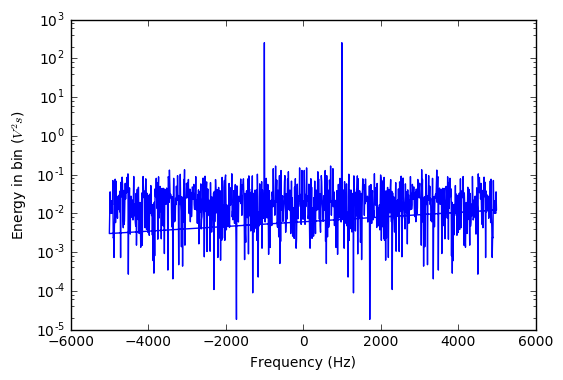

In [41]:
Exx = np.abs(X) ** 2

plt.semilogy(f, Exx)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Energy in bin ($V^2s$)')

Let's convert the FFT values to power. In the time domain, we divided the sum energy by N. This is what we do in the frequency domain, too to get average power in each freq bin. If you followed carefully, we normalized the the FFT squared magnitudes by N to get energy and again by N to get power. __This is why people prefer to normalize the FFT values by N (so the squared magnitudes are in the power units)__.

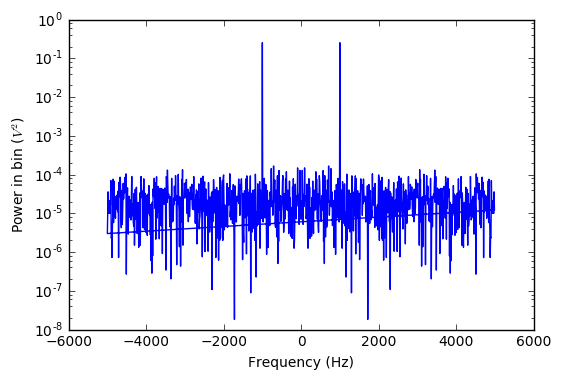

In [42]:
Pxx = Exx / N
plt.semilogy(f, Pxx)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power in bin ($V^2$)')

Due to the real time-domain samples we have a symmetric spectrum (complex conjugate). Let's take and scale the positive half of it.

(1e-06, 1)

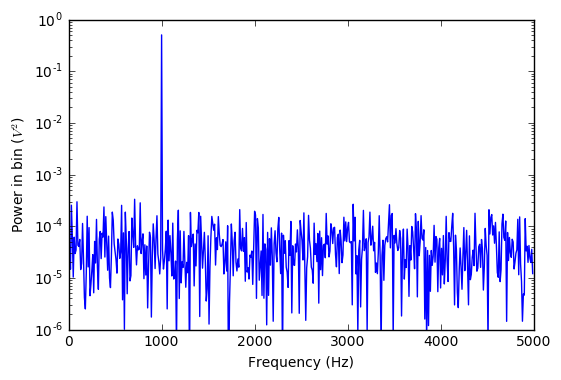

In [43]:
Pxx = Pxx[:N // 2]
Pxx[1:-2] *= 2    # conserve energy
f = f[:N // 2]

plt.semilogy(f, Pxx)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power in bin ($V^2$)')
plt.ylim(1e-6, 1)
plt.grid()

Let's compare the result with the built-in periodogram function.

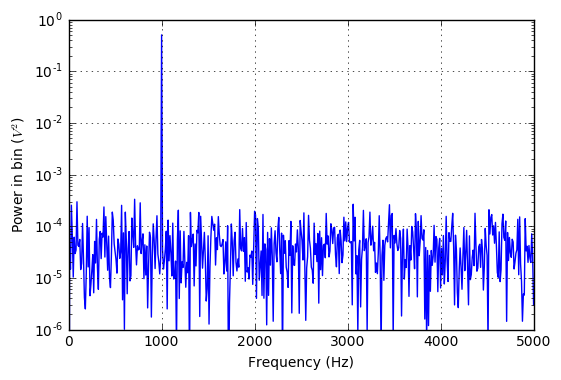

In [55]:
f2, Pxx2  = signal.periodogram(samples, FS, nfft=N, scaling='spectrum')
plt.semilogy(f2, Pxx2)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power in bin ($V^2$)')
plt.ylim(1e-6, 1)
plt.grid()
plt.show()

Calculate SNR using the frequency domain (first peak is the signal assumption).

In [50]:
f_sig_idx = np.argmax(Pxx)
SNR_f = 10 * np.log10(Pxx[f_sig_idx] / np.sum(np.delete(Pxx, f_sig_idx)))

print('SNR= %.2f dB (time domain SNR= %.2f dB)' % (SNR_f, SNR_t))

SNR= 12.81 dB (time domain SNR= 12.02 dB)


# TODOs: spectrum density, windowing

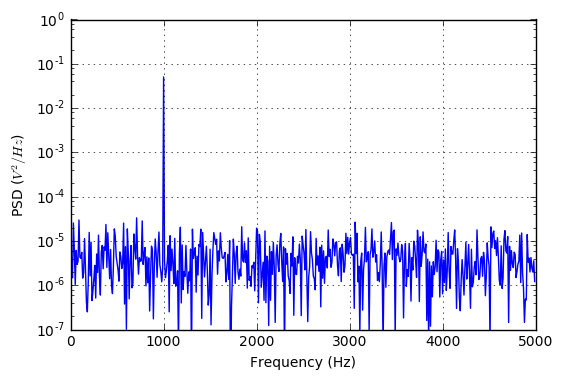

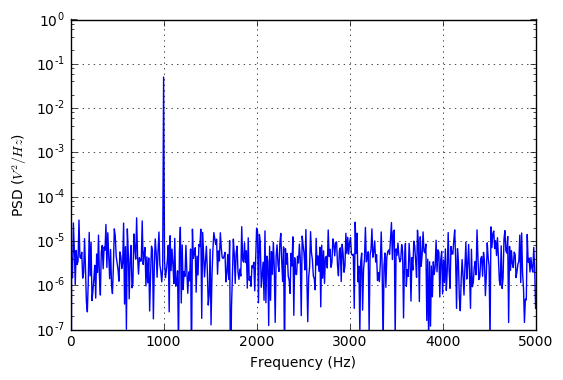

In [53]:
plt.semilogy(f, Pxx / (FS / N))
plt.xlabel('Frequency (Hz)')
plt.ylabel('PSD ($V^2/Hz$)')
plt.ylim(1e-7, 1)
plt.grid()
plt.show()

f2, Pxx2  = signal.periodogram(samples, FS, nfft=N, scaling='density')
plt.semilogy(f2, Pxx2)
plt.xlabel('Frequency (Hz)')
plt.ylabel('PSD ($V^2/Hz$)')
plt.ylim(1e-7, 1)
plt.grid()
